# Taxi orders forecast

Task is to make a forecast taxi orders model for hours. RMSE value must be lower than 48

note: on this data i decided to try different prediction models, at the end we will see the best one

## Data downloading

In [ ]:
import pandas as pd
import numpy as np
# timeline
from statsmodels.tsa.seasonal import seasonal_decompose
# splitting, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import math
!pip install -q shap
import shap
#to find training time of the model
import time
# models
from sklearn.linear_model import LinearRegression
!pip install -q catboost
from catboost import CatBoostRegressor, Pool, cv

!pip install -q lightgbm
import lightgbm as lgb

!pip install TPOT -q
from tpot import TPOTRegressor

!pip install -U lightautoml -q
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from sklearn.metrics import mean_squared_log_error

from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
# for plotting
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 564 kB 27.6 MB/s 
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
     |████████████████████████████████| 87 kB 5.0 MB/s 
     |████████████████████████████████| 173.6 MB 9.3 kB/s 
     |████████████████████████████████| 160 kB 36.6 MB/s 
     |████████████████████████████████| 294 kB 26.9 MB/s 
     |████████████████████████████████| 308 kB 53.2 MB/s 
     |████████████████████████████████| 804.1 MB 2.1 kB/s 
     |████████████████████████████████| 425 kB 63.9 MB/s 
     |████████████████████████████████| 212 kB 67.2 MB/s 
     |████████████████████████████████| 1.2 MB 40.7 MB/s 
     |████████████████████████████████| 2.8 MB 58.6 MB/s 
     |████████████████████████████████| 81 kB 8.0 MB/s 
     |████████████████████████████████| 210 kB 54.1 MB/s 
     |████████████████████████████████| 78 kB 5.7 MB/s 
     |████████████████████████████████| 49 kB 5.1 MB/s 
     |████████████████████████████████| 113 kB 60.2 MB/s 
     |██████████████

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/colab_notebooks/12-taxi-orders/Data/taxi.csv', index_col=[0], parse_dates=[0])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
df.sort_index(inplace=True)

In [ ]:
df.index.is_monotonic

True

In [ ]:
df['num_orders'].describe()

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

The data index is monotonic, in `num_orders` errors is not found

## Resampling

In [ ]:
df = df.resample('1H').sum()

## Trend checking

In [ ]:
decomposed = seasonal_decompose(df)

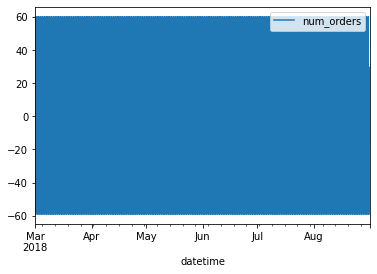

In [ ]:
decomposed.seasonal.plot()

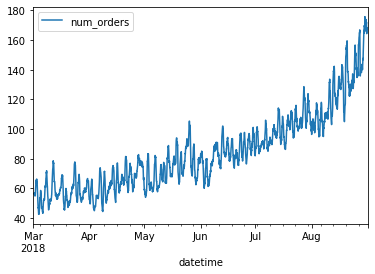

In [ ]:
decomposed.trend.plot()

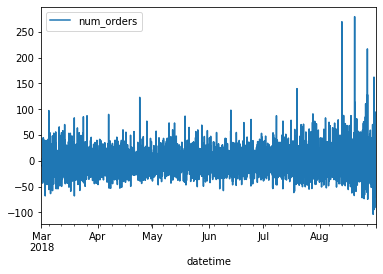

In [ ]:
decomposed.resid.plot()

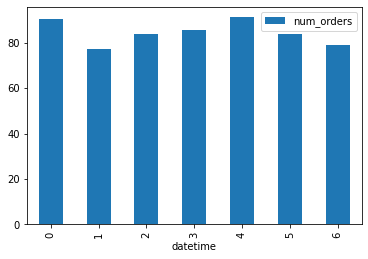

In [ ]:
pd.pivot_table(df,
               index=df.index.dayofweek,
               values='num_orders',
               aggfunc='mean').plot(kind='bar')

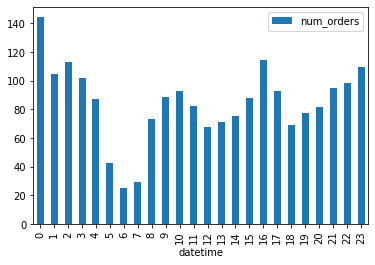

In [ ]:
pd.pivot_table(df,
               index=df.index.hour,
               values='num_orders',
               aggfunc='mean').plot(kind='bar')

In data there is only 2018 year, so it doesn't have seasonal. The trend plot have increasing values from month to month in considering period. Maximum mean amount of taxi orders on Sundays and Fridays, minimum on Mondays and Saturdays. In twenty-four hours maximum on 00:00 - 00:59, 23:00-23:59 and 16:00 - 16:59, minimum in a period of time from 05:00 to 07:59

## Features adding

In [ ]:
df['rolling_mean'] = df['num_orders'].rolling(15).mean()
df['rolling_std'] = df['num_orders'].rolling(15).std()

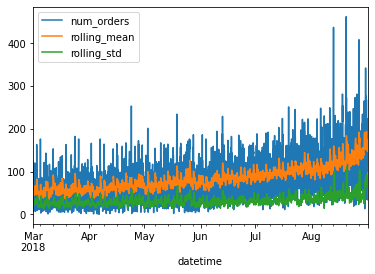

In [ ]:
df.plot()

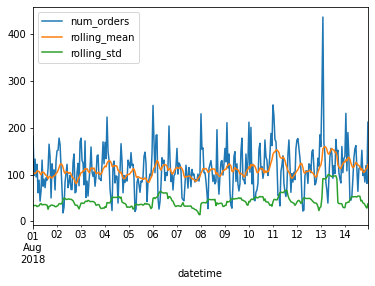

In [ ]:
df['2018-08-01': '2018-08-14'].plot()

In [ ]:
# df['month'] = df.index.month
df['dayofweek'] = df.index.dayofweek
# df['day'] = df.index.day
df['hour'] = df.index.hour

In [ ]:
df['lag_1'] = df['num_orders'].shift(1)
df['lag_2'] = df['num_orders'].shift(2)
df['lag_3'] = df['num_orders'].shift(3)

In [ ]:
df.sample(3)

,num_orders,rolling_mean,rolling_std,dayofweek,hour,lag_1,lag_2,lag_3
datetime,,,,,,,,
2018-04-19 00:00:00,159,78.400000,34.215285,3,0,142.0,77.0,98.0
2018-05-28 15:00:00,97,86.866667,47.014993,0,15,89.0,68.0,65.0
2018-06-08 05:00:00,36,88.533333,34.516801,4,5,83.0,110.0,142.0


### Holidays adding

In [ ]:
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, DateOffset, nearest_workday, MO
import pandas as pd
import datetime as dt

class RuBusinessCalendar(AbstractHolidayCalendar):
    """ Custom Holiday calendar for France based on
        https://en.wikipedia.org/wiki/Public_holidays_in_Russia
    """
    rules = [
     Holiday('New Year', month=1, day=1, observance=nearest_workday),
     Holiday('New Year', month=1, day=2, observance=nearest_workday),
     Holiday('New Year', month=1, day=3, observance=nearest_workday),
     Holiday('New Year', month=1, day=4, observance=nearest_workday),
     Holiday('New Year', month=1, day=5, observance=nearest_workday),
     Holiday('New Year', month=1, day=6, observance=nearest_workday),
     Holiday('Christmas', month=1, day=7, observance=nearest_workday),
     Holiday('New Year', month=1, day=8, observance=nearest_workday),
     Holiday('23 feb', month=2, day=23, observance=nearest_workday),
     Holiday('8 march', month=3, day=8, observance=nearest_workday),
     Holiday('1 may', month=5, day=1, observance=nearest_workday),
     Holiday('9 may', month=5, day=9, observance=nearest_workday),
     Holiday('Nat day', month=6, day=12, observance=nearest_workday),
     Holiday('Un day', month=11, day=4, observance=nearest_workday),
     ]

cal= RuBusinessCalendar()

In [ ]:
df['is_holiday'] = df.index.isin([d for d in cal.holidays()])

In [ ]:
df[df['is_holiday'] == 1]

,num_orders,rolling_mean,rolling_std,dayofweek,hour,lag_1,lag_2,lag_3,is_holiday
datetime,,,,,,,,,
2018-03-08,143,71.066667,34.814748,3,0,94.0,127.0,108.0,True
2018-05-01,81,72.466667,19.577198,1,0,77.0,85.0,88.0,True
2018-05-09,121,65.533333,30.397055,2,0,67.0,58.0,82.0,True
2018-06-12,142,77.133333,22.971618,1,0,87.0,90.0,105.0,True


It were added new features with aggregated values of taxi orders amount for better model predictions:
- `rolling_mean`
- `rolling_std`
- `month`
- `dayofweek`
- `day`
- `hour`
- `lag_1`
- `lag_2`
- `lag_3`
- `is_holiday`

## Models building

It will be used few kinds of models and their RSME will be added to a dictionary

### LinearRegression

In [ ]:
df = df.dropna()

In [ ]:
LABEL = 'num_orders'

In [ ]:
X = df.drop(LABEL, axis=1)
y = df[LABEL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=False)

In [ ]:
df_res_compare = y_test.to_frame()

In [ ]:
model = LinearRegression()

In [ ]:
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
prediction = model.predict(X_test).astype(int)

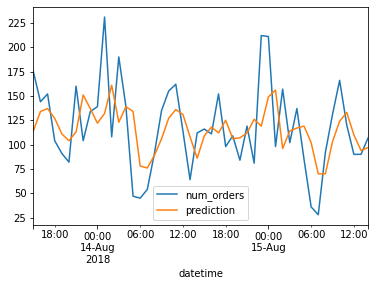

In [ ]:
df_res_compare['prediction'] = prediction
df_res_compare.head(48).plot()

In [ ]:
result_RSME = {'LinearRegression' : mean_squared_error(y_test, prediction)**0.5}

### Catboost

In [ ]:
pool = Pool(X, y)

In [ ]:
RANDOM = 22

In [ ]:
params = {'loss_function': 'RMSE',
          'eval_metric':'RMSE',
          'random_seed': RANDOM,
          'early_stopping_rounds': 200,
          'verbose': 200
          }

In [ ]:
model = CatBoostRegressor(**params)

In [ ]:
cv_data = cv(pool, params=model.get_params())

Training on fold [0/3]
0:	learn: 92.9067620	test: 94.2471966	best: 94.2471966 (0)	total: 52.5ms	remaining: 52.4s
200:	learn: 21.7803415	test: 24.7960670	best: 24.7960670 (200)	total: 532ms	remaining: 2.12s
400:	learn: 18.6449835	test: 22.9924831	best: 22.9917385 (399)	total: 1s	remaining: 1.5s
600:	learn: 16.8293720	test: 22.3655833	best: 22.3655833 (600)	total: 1.45s	remaining: 961ms
800:	learn: 15.5764956	test: 22.0546112	best: 22.0545178 (799)	total: 1.93s	remaining: 479ms
999:	learn: 14.5546713	test: 21.9073691	best: 21.9073691 (999)	total: 2.38s	remaining: 0us

bestTest = 21.9073691
bestIteration = 999

Training on fold [1/3]
0:	learn: 93.3402000	test: 93.3854177	best: 93.3854177 (0)	total: 2.36ms	remaining: 2.36s
200:	learn: 22.0247923	test: 23.6503509	best: 23.6503509 (200)	total: 468ms	remaining: 1.86s
400:	learn: 18.9862723	test: 22.2261619	best: 22.2260111 (399)	total: 913ms	remaining: 1.36s
600:	learn: 17.1714667	test: 21.6191384	best: 21.6156982 (599)	total: 1.38s	remaining

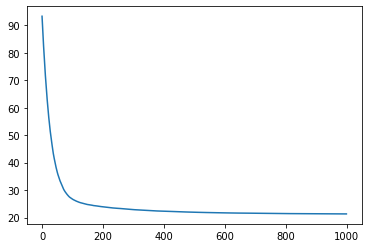

In [ ]:
cv_data['test-RMSE-mean'].plot()

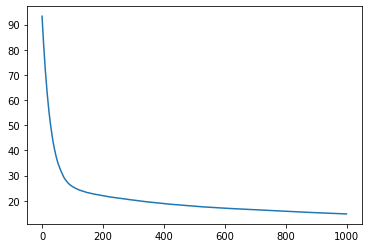

In [ ]:
cv_data['train-RMSE-mean'].plot()

In [ ]:
pool = Pool(X_train, y_train)

In [ ]:
model.fit(pool)

Learning rate set to 0.05089
0:	learn: 37.7083078	total: 2.68ms	remaining: 2.68s
200:	learn: 18.7490805	total: 410ms	remaining: 1.63s
400:	learn: 16.2131554	total: 853ms	remaining: 1.27s
600:	learn: 14.6903580	total: 1.27s	remaining: 844ms
800:	learn: 13.5180421	total: 1.72s	remaining: 428ms
999:	learn: 12.5920645	total: 2.14s	remaining: 0us


In [ ]:
prediction = model.predict(X_test).astype(int)

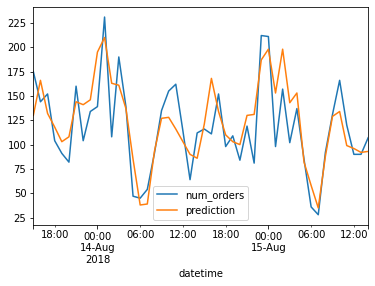

In [ ]:
df_res_compare['prediction'] = prediction
df_res_compare.head(48).plot()

In [ ]:
result_RSME['Catboost'] = mean_squared_error(y_test, prediction)**0.5

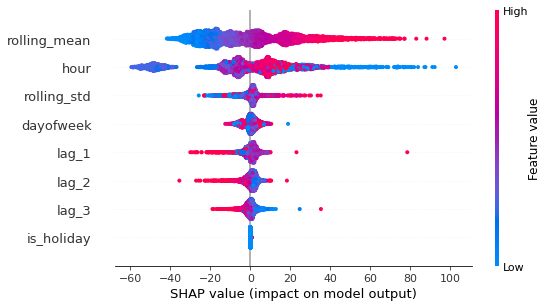

In [ ]:
shap_values = model.get_feature_importance(pool,type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
shap.summary_plot(shap_values, X_train)

### Lightgbm

In [ ]:
params_lgb = {'objective': 'regression',
              'metric': 'rmse',
              'random_seed': RANDOM
             }

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [ ]:
model = lgb.train(params_lgb,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=200,
                      num_boost_round=1000)

[200]	training's rmse: 11.1645	valid_1's rmse: 39.004
[400]	training's rmse: 7.93847	valid_1's rmse: 39.491
[600]	training's rmse: 5.95206	valid_1's rmse: 39.9082
[800]	training's rmse: 4.5259	valid_1's rmse: 40.284
[1000]	training's rmse: 3.54497	valid_1's rmse: 40.599


In [ ]:
prediction = model.predict(X_test).astype(int)

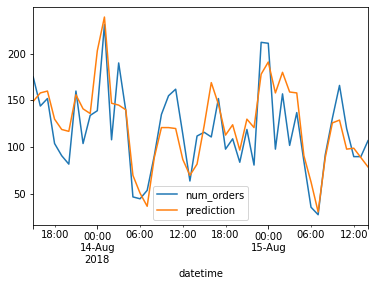

In [ ]:
df_res_compare['prediction'] = prediction
df_res_compare.head(48).plot()

In [ ]:
result_RSME['Lightgbm'] = mean_squared_error(y_test, prediction)**0.5

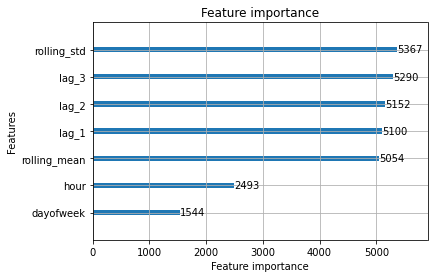

In [ ]:
%matplotlib inline
lgb.plot_importance(model)

### TPOT

In [ ]:
model = TPOTRegressor(
    generations=3,
    population_size=10,
    random_state=RANDOM,
    verbosity=1,
    # n_jobs=-1,
    max_time_mins=30,
    scoring='neg_mean_squared_error'
    )

In [ ]:
%%time
model.fit(X_train, y_train.values.ravel())

Best pipeline: GradientBoostingRegressor(input_matrix, alpha=0.99, learning_rate=0.1, loss=huber, max_depth=6, max_features=0.7000000000000001, min_samples_leaf=7, min_samples_split=12, n_estimators=100, subsample=0.9500000000000001)
CPU times: user 1min 59s, sys: 4.91 s, total: 2min 4s
Wall time: 2min 4s


TPOTRegressor(generations=3, max_time_mins=30, population_size=10,
              random_state=22, scoring='neg_mean_squared_error', verbosity=1)

In [ ]:
prediction = model.predict(X_test).astype(int)

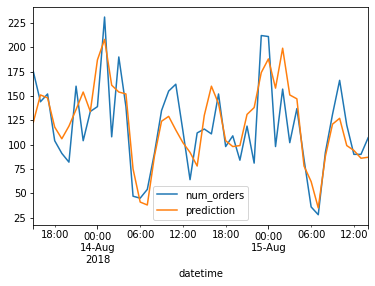

In [ ]:
df_res_compare['prediction'] = prediction
df_res_compare.head(48).plot()

In [ ]:
result_RSME['TPOT'] = mean_squared_error(y_test, prediction)**0.5

### TabularAutoML

In [ ]:
X_train[LABEL] = y

In [ ]:
%%time
automl = TabularAutoML(task = Task('reg'),
                       reader_params = {#'cv': N_FOLDS, 
                                        'random_state': RANDOM},
                       tuning_params = {'max_tuning_iter': 20, 'max_tuning_time': 30})
oof_pred = automl.fit_predict(X_train, roles = {'target': LABEL})
test_pred = automl.predict(X_test)

CPU times: user 2min 28s, sys: 8.77 s, total: 2min 37s
Wall time: 1min 43s


In [ ]:
prediction = test_pred.data[:, 0].astype(int)

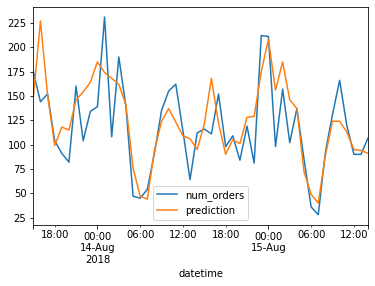

In [ ]:
df_res_compare['prediction'] = prediction
df_res_compare.head(48).plot()

In [ ]:
result_RSME['TabularAutoML'] = mean_squared_error(y_test, prediction)**0.5

### Combine predictors using stacking

In [ ]:
# The parameters inside the models can be varied 
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'squared_error'}
GB_model= GradientBoostingRegressor(**params) 
lin_model = Lasso(alpha=0.005, random_state=0)
RF_model = RandomForestRegressor(n_estimators=400,random_state=RANDOM)
# Get these models in a list
estimators = [('Random Forest', RF_model),
              ('Lasso', lin_model),
              ('Gradient Boosting', GB_model)]
#Stack these models with StackingRegressor
stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())

In [ ]:
X = df.drop(LABEL, axis=1)
y = df[LABEL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=False)

In [ ]:
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('True')
    ax.set_ylabel('Prediction')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + 'n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)

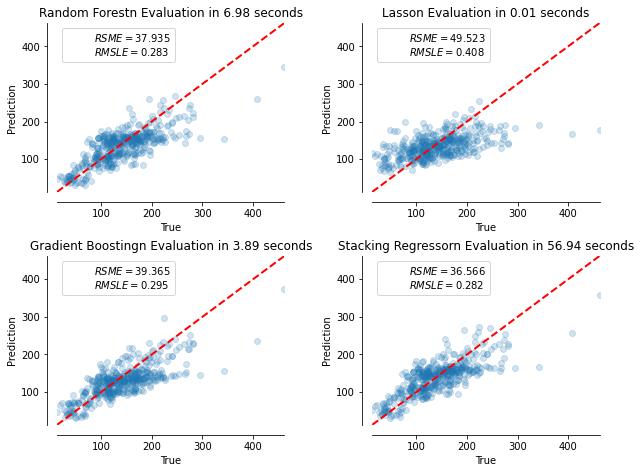

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)
errors_list=[]
for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               stacking_regressor)]):
    start_time = time.time()
    model = est.fit(X_train, y_train)
                     
    elapsed_time = time.time() - start_time
    
    pred = model.predict(X_test)
    errors = y_test - model.predict(X_test)
    errors_list.append(errors)
    # test_r2= r2_score(np.exp(y_test), np.exp(pred))
    rsme = mean_squared_error(y_test, pred.astype(int))**0.5 ###
    
    test_rmsle=math.sqrt(mean_squared_log_error(y_test,pred))
    plot_regression_results(ax,y_test,pred,name,(
        # r'$R^2={:.3f}$' + '\n' + r'$RMSLE={:.3f}$'
        r'$RSME={:.3f}$' + '\n' + r'$RMSLE={:.3f}$'###
        ).format(
                                # test_r2,
                                rsme, ###
                                test_rmsle),elapsed_time)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

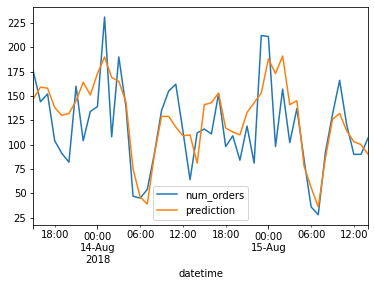

In [ ]:
df_res_compare['prediction'] = pred.astype(int)
df_res_compare.head(48).plot()

In [ ]:
result_RSME['Stacking'] = mean_squared_error(y_test, pred.astype(int))**0.5

### Prophet

добавить праздники

In [ ]:
!pip install prophet -q
from prophet import Prophet

     |████████████████████████████████| 65 kB 3.3 MB/s 
     |████████████████████████████████| 49 kB 3.7 MB/s 
     |████████████████████████████████| 45 kB 2.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [ ]:
df.head(3)

,num_orders,rolling_mean,rolling_std,dayofweek,hour,lag_1,lag_2,lag_3,is_holiday
datetime,,,,,,,,,
2018-03-01 14:00:00,48,53.000000,33.353089,3,14,32.0,30.0,96.0,False
2018-03-01 15:00:00,66,49.133333,27.357074,3,15,48.0,32.0,30.0,False
2018-03-01 16:00:00,43,46.333333,25.510969,3,16,66.0,48.0,32.0,False


In [ ]:
X = df['num_orders']

In [ ]:
X = X.reset_index()

In [ ]:
X = X.rename(columns={"datetime": "ds", "num_orders": "y"})

In [ ]:
X.head(3)

,ds,y
0,2018-03-01 14:00:00,48
1,2018-03-01 15:00:00,66
2,2018-03-01 16:00:00,43


In [ ]:
X_train, X_test = train_test_split(X, test_size=0.10, shuffle=False)

In [ ]:
df_holidays = pd.DataFrame(cal.holidays(start=df.index.min(), 
                                        end=df.index.max(), 
                                        return_name=True
                                        )).reset_index().rename(columns={'index': "ds", 0: "holiday"})

In [ ]:
df_holidays

,ds,holiday
0,2018-03-08,8 march
1,2018-05-01,1 may
2,2018-05-09,9 may
3,2018-06-12,Nat day


In [ ]:
m = Prophet(holidays=df_holidays)
m.fit(X_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(freq='H', periods=441, include_history=False)

In [ ]:
future.head(3)

,ds
0,2018-08-13 15:00:00
1,2018-08-13 16:00:00
2,2018-08-13 17:00:00


In [ ]:
forecast = m.predict(future)

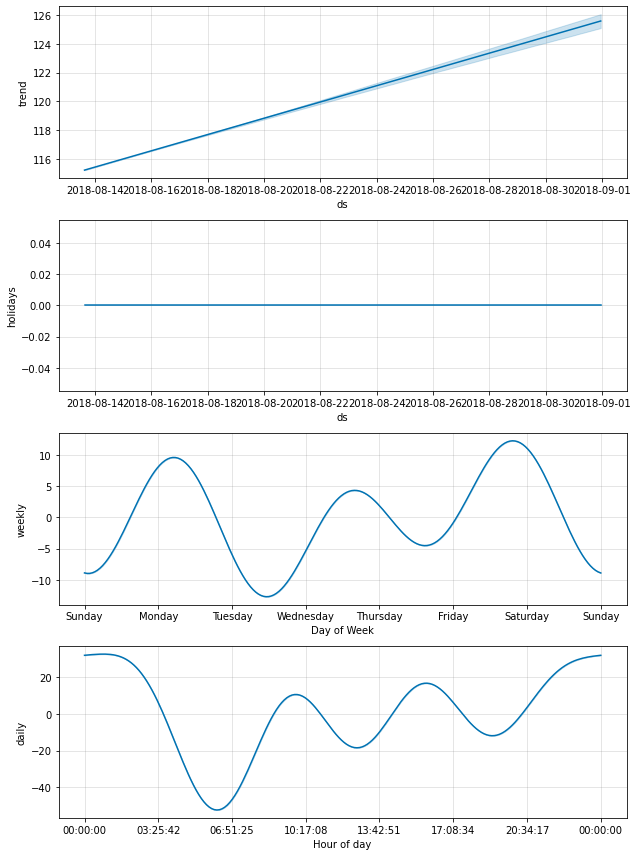

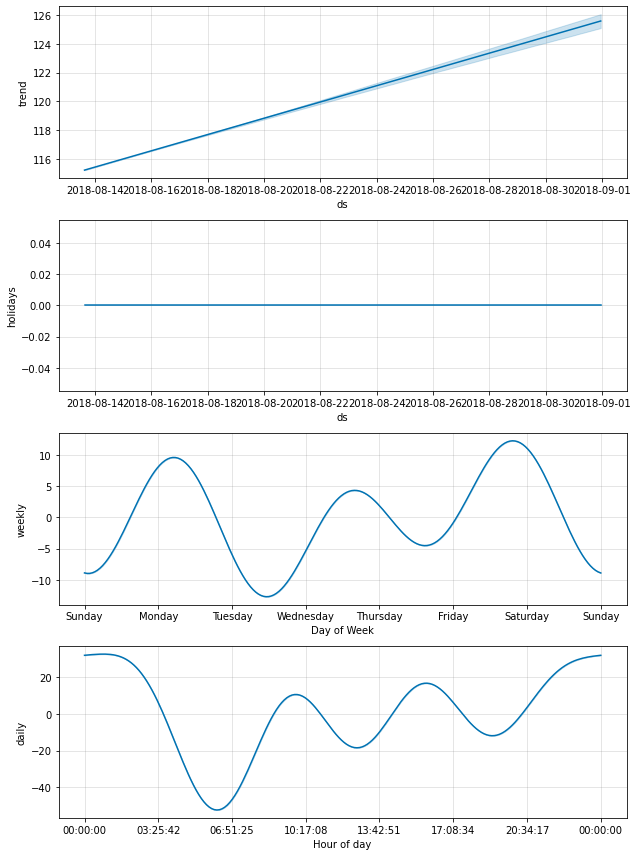

In [ ]:
m.plot_components(forecast)

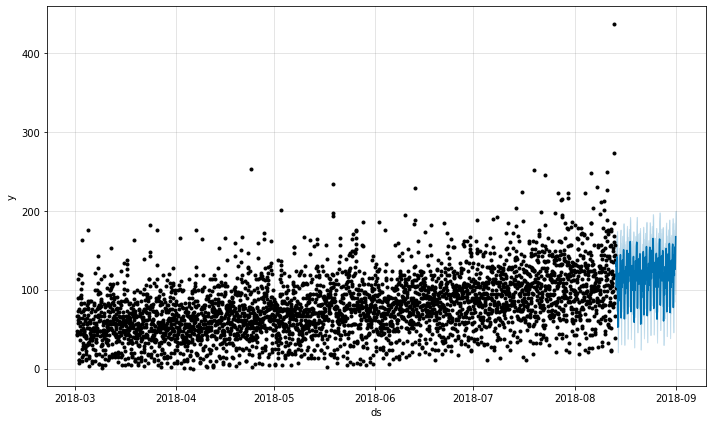

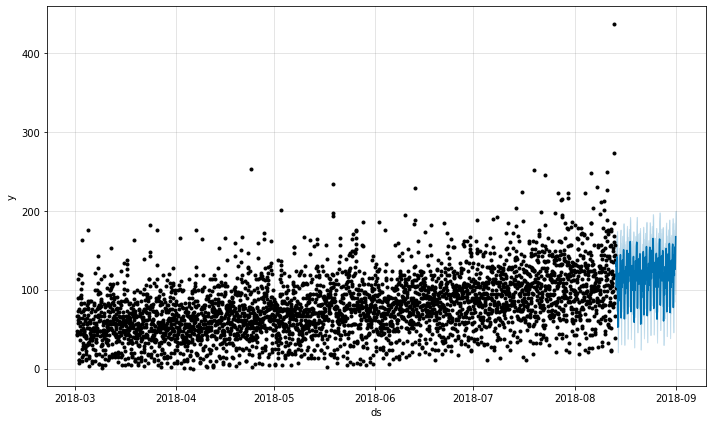

In [ ]:
m.plot(forecast)

In [ ]:
forecast.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,1 may,1 may_lower,1 may_upper,8 march,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-08-13 15:00:00,115.224495,101.398381,161.285865,115.224495,115.224495,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.128167,4.128167,4.128167,0.0,0.0,0.0,130.175107
1,2018-08-13 16:00:00,115.248053,100.554046,166.693533,115.248053,115.248053,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.094279,3.094279,3.094279,0.0,0.0,0.0,135.062800
2,2018-08-13 17:00:00,115.271611,94.788271,154.959786,115.271611,115.271611,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.009725,2.009725,2.009725,0.0,0.0,0.0,125.511565


In [ ]:
forecast = forecast.set_index('ds')['yhat']

In [ ]:
forecast.head(3)

ds
2018-08-13 15:00:00    130.175107
2018-08-13 16:00:00    135.062800
2018-08-13 17:00:00    125.511565
Name: yhat, dtype: float64

In [ ]:
result_RSME['Prophet'] = mean_squared_error(y_test, forecast.astype(int))**0.5

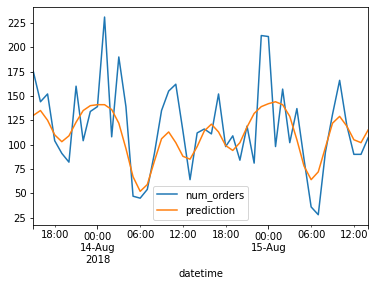

In [ ]:
df_res_compare['prediction'] = forecast.astype(int)
df_res_compare.head(48).plot()

## Conclusion

In [ ]:
pd.DataFrame(result_RSME.items(), columns = ['model', 'RSME']).style.background_gradient().set_precision(2)

this method is deprecated in favour of `Styler.format(precision=..)`


,model,RSME
0,LinearRegression,49.52
1,Catboost,39.87
2,Lightgbm,40.65
3,TPOT,39.95
4,TabularAutoML,36.29
5,Stacking,36.57
6,Prophet,48.54


- In data there is only 2018 year, so it doesn't have seasonal. The trend plot have increasing values from month to month in considering period. Maximum mean amount of taxi orders on Sundays and Fridays, minimum on Mondays and Saturdays. In twenty-four hours maximum on 00:00 - 00:59, 23:00-23:59 and 16:00 - 16:59, minimum in a period of time from 05:00 to 07:59
- It is needed to made forecast for hour, so values were resampled to 1 hour sum
- There were added new features with aggregated values of taxi orders amount for better model predictions:
  - `rolling_mean`
  - `rolling_std`
  - `month`
  - `dayofweek`
  - `day`
  - `hour`
  - `lag_1`
  - `lag_2`
  - `lag_3`
  - `is_holiday`
- different kinds of models were considered, the best RMSE is 36.29 it has model TabularAutoML